# Analysis of hazardous asteroids' orbital parameters

Using data on already discovered asteroid's we'll try to analyse orbital parameters of hazardous asteroids and  find out orbits or familes of orbits with high probability of yet undiscovered potentially hazardous asteroids existance.

In [1]:
%matplotlib inline
import pickle, sys, os, time
import numpy as np
# import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm

import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al

### ASTEROID DATABASE

**Load asteroid database:**

In [2]:
# database_path = "./asteroid_data/latest_fulldb.csv"

# if not os.path.exists(database_path):
#     database_url = "http://www.ianww.com/latest_fulldb.csv"
#     rdb.retrieve_database(database_url, database_path, jobtime=True)

columns = ['a', 'e', 'i', 'w', 'om', 'q', 'H', 'neo', 
               'pha', 'moid', 'per', 'n', 'ma', 'epoch']
# database = rdb.read_csv(database_path, sep=',', usecols=columns,
#                         low_memory=False, jobtime=True)

database = rdb.load_database(columns, jobtime=True)
database.head(n=5)

Loading asteroid database...
Asteroid database loaded in 5.803000 seconds.


,neo,pha,H,epoch,e,a,q,i,om,w,ma,n,per,moid
0,N,N,3.34,2457200.5,0.075783,2.767972,2.558208,10.592305,80.327198,72.654146,138.662175,0.214023,1682.058334,1.59427
1,N,N,4.13,2457200.5,0.231158,2.772004,2.131234,34.840258,173.092151,309.965564,120.919026,0.213557,1685.734286,1.23108
2,N,N,5.33,2457200.5,0.255830,2.671073,1.987732,12.986619,169.860102,248.399241,78.215743,0.225775,1594.509751,1.03987
3,N,N,3.20,2457200.5,0.088834,2.361913,2.152095,7.140096,103.849635,151.188504,75.172676,0.271524,1325.849757,1.13975
4,N,N,6.85,2457200.5,0.191188,2.573480,2.081462,5.368549,141.595776,358.969279,307.898284,0.238739,1507.924540,1.09509


**Extract NEOs:**

In [3]:
neo, num_neo = rdb.get_neo(database, columns)

**Recalculate MOID using orbital parameters:**

In [4]:
#rdb.calc_moid(neo, verbose=True)

**Split NEOs by groups:**

In [5]:
apollos, num_apollos = rdb.get_apollos(neo)
atens, num_atens = rdb.get_atens(neo)
amors, num_amors = rdb.get_amors(neo)

# print "apollos:", num_apollos, "neo:", num_neo, "ratio:", num_apollos/float(num_neo)
# print "atens:", num_atens, "neo:", num_neo, "ratio:", num_atens/float(num_neo)
# print "amors:", num_amors, "neo:", num_neo, "ratio:", num_amors/float(num_neo)

**Cut off apollo asteroids with extreme orbital parameters:**

In [6]:
apollos, num_apollos = rdb.cutoff_outcasts(apollos)

## GENERATE RANDOM ASTEROIDS

**Specify a subset of asteroid parameters:**

In [7]:
names = ['a', 'i', 'w', 'om', 'q']
data_subset = apollos[names]

**Pick an appropriate range of continuous distributions to fit parameters subset:**

In [8]:
statdists = [ss.johnsonsb, ss.exponweib, go.HarmonicDistribution(), go.HarmonicDistribution(), ss.genlogistic]

**Find curve fitted continuous distributions:**

Data cdf(xmax): 1.000000 	johnsonsb_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	exponweib_cdf(xmax): 0.984229
Data cdf(xmax): 1.000000 	harmonic_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	harmonic_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	genlogistic_cdf(xmax): 0.999663


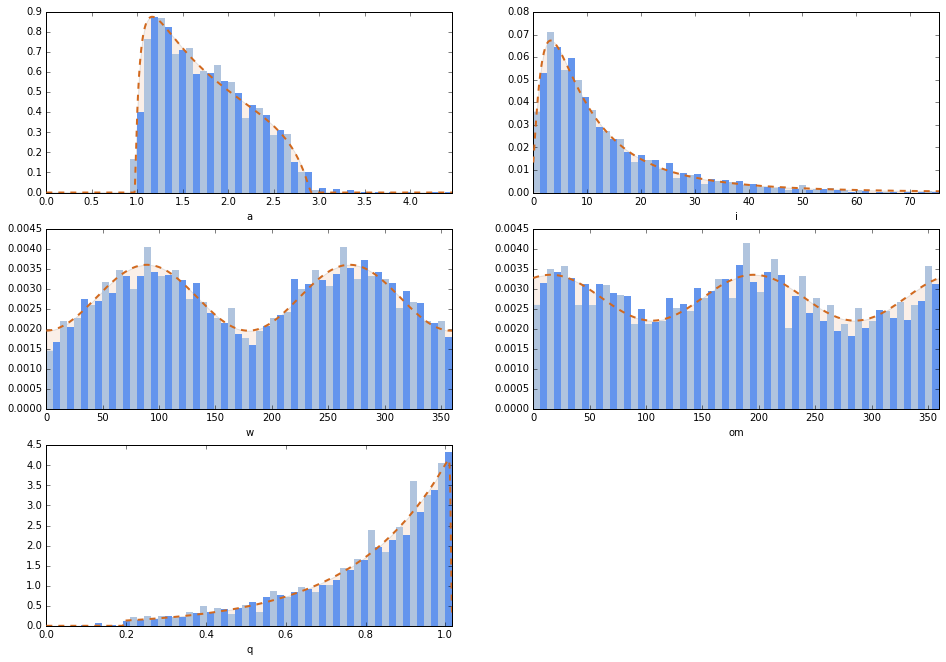

In [9]:
distlist = go.get_param_distributions(data_subset, names, statdists, n=30, verbose=True)
go.plot_param_distributions(distlist, names, figsize=(16, 11))

**Generate random asteroids on the basis of the fitted parameter distributions:**

In [10]:
# params_minmax = go.get_param_bounds(data_subset, names)
# randdata = go.gen_rand_orbits(params_minmax, names, distlist, num=1e4)

**Calculate Minimum Earth OrbitIntersection Distance**

In [11]:
# rdb.calc_moid(apollos, jobtime=True)
# rdb.calc_moid(randdata, jobtime=True)

**Extract hazardous and nonhazardous orbits**

In [12]:
# haz_real, nohaz_real = rdb.get_hazMOID(apollos)
# haz_gen, nohaz_gen = rdb.get_hazMOID(randdata)

**Save results to hard drive:**

In [13]:
dumps = ['./asteroid_data/haz_rand_test.p', 
           './asteroid_data/nohaz_rand_test.p',
           './asteroid_data/haz_test.p', 
           './asteroid_data/nohaz_test.p']

# datasets = [haz_gen, nohaz_gen, haz_real, nohaz_real]
# for dataset, target in zip(datasets, dumps):
#     rdb.dumpObject(dataset, target)

## ANALYSE ORBITAL PARAMETERS WITH MACHINE LEARNIG

**Load saved datasets:**

In [14]:
haz_gen, nohaz_gen, haz_real, nohaz_real = map(rdb.loadObject, dumps)

**Split generated orbits into training and testing datasets**

prepare...


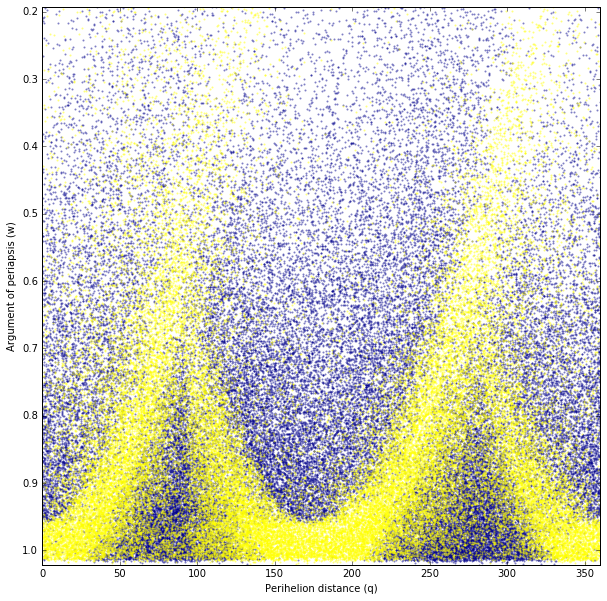

In [15]:
datasets = ld.prepare_data(cutcol=['w', 'q'], datasets=[haz_gen, nohaz_gen, haz_real, nohaz_real])
labels=['Argument of periapsis (w)', 'Perihelion distance (q)']
datasets_x = [datasets[i][:, :-1] for i in range(4)] 
haz_gen, nohaz_gen, haz_real, nohaz_real = datasets_x
vd.plot_distribution(haz=haz_gen, nohaz=nohaz_gen,
                     labels=['Perihelion distance (q)', 'Argument of periapsis (w)'])

**Normalize dataset's dimensions:**

In [16]:
x, y = haz_gen[:, 0], haz_gen[:, 1]
scales = [(x.min(), x.max()),  (y.min(), y.max())]
datasets_norm = map(al.normalize_dataset, [haz_gen, nohaz_gen, haz_real, nohaz_real])

**Classify hazardous and nonhazardous asteroids**

clf: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=2,
           weights='uniform')
score: 0.726732673267
predict_haz_fraction: 0.547100424328
true_haz_fraction: 0.537765205092


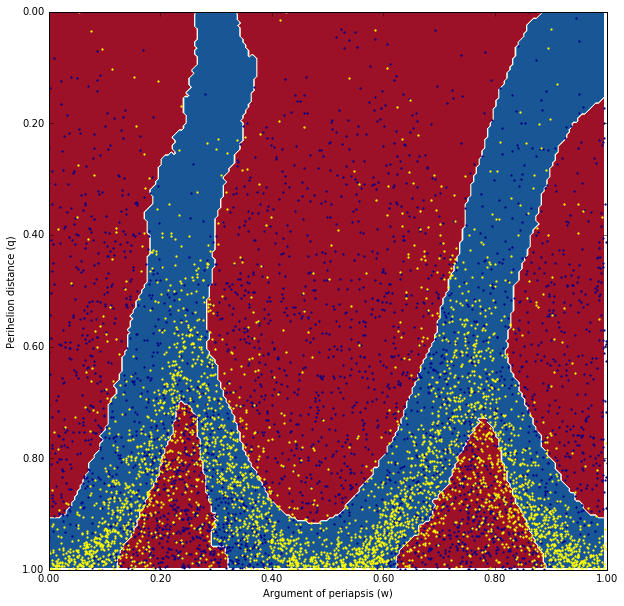

In [17]:
clf = neighbors.KNeighborsClassifier(n_neighbors=500)
xtrain, clf = al.classify_hazardous(datasets, clf, crossval=False)
vd.plot_classifier(xtrain, clf, num=200, haz=haz_real, nohaz=nohaz_real, cmap='RdBu',labels=labels)

**Split data by density-based clusters and estimate hazardous asteroids mass fraction in clusters**

In [18]:
# Multilayer DBSCAN parameters 

# eps = [0.005, 0.0055, 0.008, 0.012]
# min_samples = [200, 180, 160, 100]
eps = [0.0188, 0.02, 0.027, 0.04]
min_samples = [275, 220, 140, 100]
dens_layers = zip(eps, min_samples)

haz_prob: [0.87305295950155759, 0.69281045751633985, 0.53210116731517509, 0.25328947368421051, 0.14076246334310852]


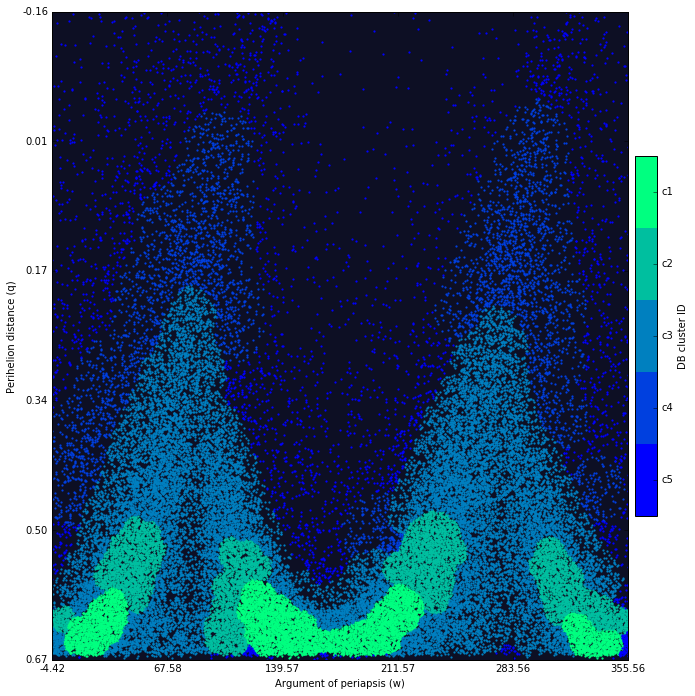

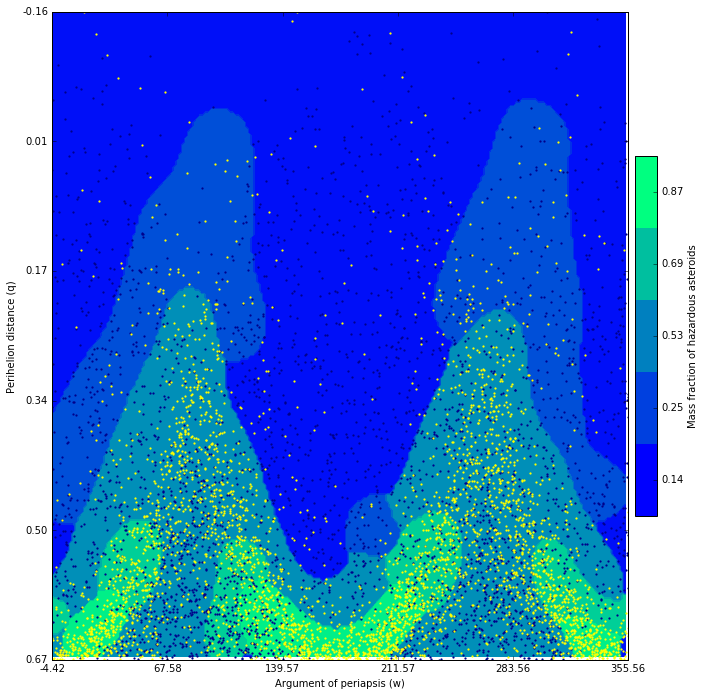

In [19]:
# clf = KNeighborsClassifier(n_neighbors=int(0.01*len(data)))
clf = svm.SVC(gamma=100.) #kernel='poly'
clusters, xtrain, clf, haz_prob = al.classify_clusters(haz_gen, clf, haz_real, 
                                                 nohaz_real, dens_layers)
vd.plot_densclusters(clusters, scales=scales, labels=labels)
vd.plot_classifier(xtrain, clf, num=200, haz=haz_real, nohaz=nohaz_real,
                   clustprobs=haz_prob, scales=scales, labels=labels)